### Análisis de Efecto Diferencial de El Niño-Southern Oscillation (ENSO) sobre la Productividad de Caña Pantaleon Guatemala

El Índice Océanico del Niño (Oceanic Niño Index ONI) se ha convertido en el *estándar de-facto* que el NOAA (National Oceanic and Atmospheric Administration) utiliza para clasificar eventos de **El Niño** (calientes) y **La Niña** (fríos) en el Pacífico Oriental Tropical (también conocido como El Niño Southern Oscillation ENSO). Consiste en **la media móvil consecutiva trimestral** de la temperatura superficial del óceano (Sea Surface Temperature o SST) en la *región Niño 3.4* (i.e., 5oN-5oS, 120o-170oW) que está por arriba (o por debajo) del umbral de +0.5°C (-0.5°C). 

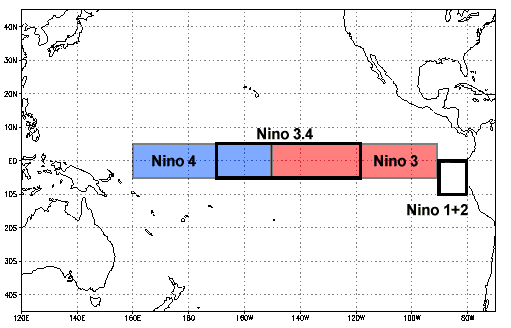

El umbral se descompone posteriormente en **Débil** (con una anomalía SST entre |0.5| y |0.9|), **Moderada** (|1.0| a |1.4|), **Fuerte** (|1.5| a |1.9|) y **Muy Fuerte** (≥ |2.0|).

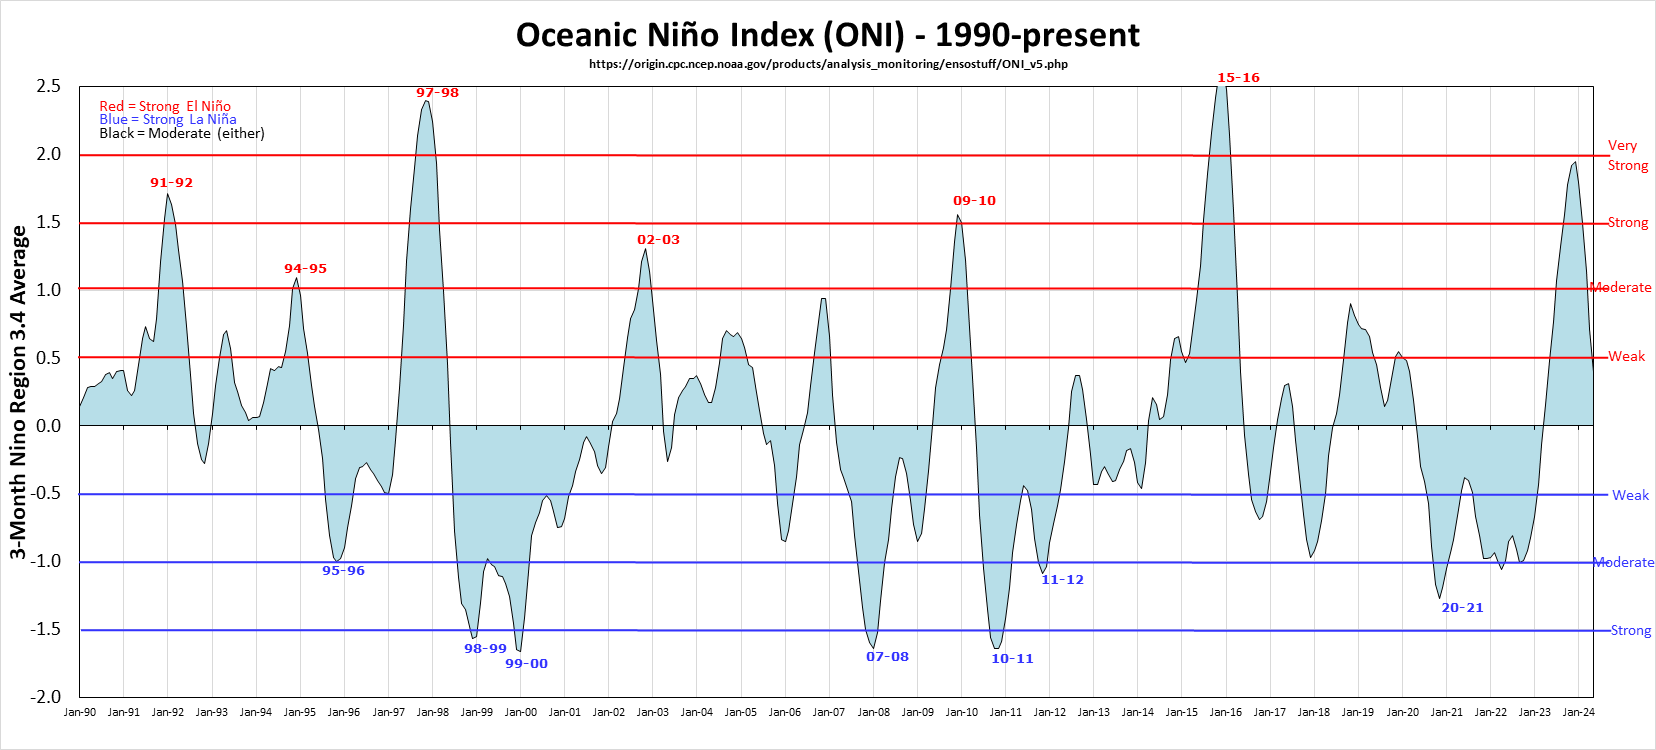

*   https://ggweather.com/enso/oni.htm
*   https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

El siguiente trabajo estudia la relación entre la intensidad de los fenómenos de *El Niño / La Niña* (medida como intensidad de la anomalía ONI) y el Rendimiento de Caña (toneladas de caña por hectárea TCH) para Ingenio Pantaleón, Guatemala.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

from sklearn.ensemble import RandomForestRegressor

### Dataset Rendimientos de Caña en Ingenio Pantaleón Guatemala

Este dataset contiene la agregación anual de caña cosechada y área cosechada, cuyo cociente determina el rendimiento de caña del año **TCH** (t caña/hectárea). Así mismo, la cantidad de azúcar medida en el Core Sampler determina el rendimiento de azúcar del año **Rend** (kg Azúcar/t caña).

In [2]:
# .csv Guatemala Yield Data
gt_yield_df = pd.read_csv("Yield_GT.csv")
#gt_yield_df = gt_yield_df[gt_yield_df['Año'] >= 2000]
gt_yield_df['Year'] = pd.to_datetime(gt_yield_df['Año'],format='%Y') + pd.offsets.YearEnd()
gt_yield_df = gt_yield_df.set_index('Year')
gt_yield_df

,Año,TCH,Rend
Year,,,
1993-12-31,1993,95.510000,104.610000
1994-12-31,1994,90.650000,104.520000
1995-12-31,1995,99.910000,99.330000
1996-12-31,1996,94.040000,96.710000
1997-12-31,1997,91.520000,101.680000
1998-12-31,1998,105.250000,99.660000
1999-12-31,1999,88.840000,101.940000
2000-12-31,2000,77.340000,115.220000
2001-12-31,2001,83.710000,115.120000


<Axes: title={'center': 'Rendimiento Caña Ingenio Pantaleon Guatemala'}, xlabel='Year'>

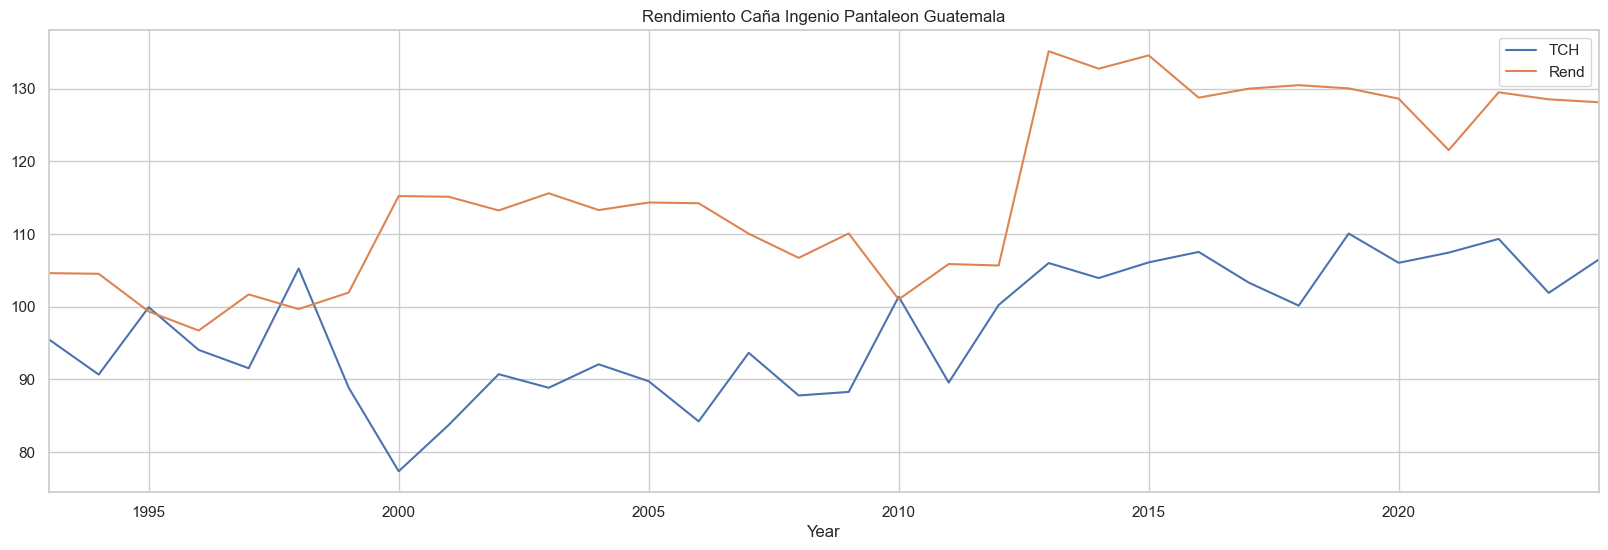

In [3]:
sns.set_theme(style="whitegrid")
gt_yield_df[['TCH','Rend']].plot(figsize=(20,6),grid=True,title='Rendimiento Caña Ingenio Pantaleon Guatemala')

### Dataset ONI

Este dataset contiene valores de la anomalía SST en la región 3.4 de El Niño.

In [4]:
# .csv Oceanic Niño Index Data
oni_df = pd.read_csv("ONI_2024.csv")
oni_df['ONI'] = oni_df['Anomaly'].rolling(3).mean()
oni_df.dropna(inplace=True)
oni_df = oni_df[oni_df['Year'] >= 1993]
oni_df = oni_df.groupby('Year').mean()
oni_df['Year'] = oni_df.index
oni_df['Year'] = pd.to_datetime(oni_df['Year'],format='%Y') + pd.offsets.YearEnd()
oni_df = oni_df.set_index('Year')
oni_df

,Month,Total,Clim_Adjust,Anomaly,ONI
Year,,,,,
1993-12-31,6.5,27.381667,27.057500,0.323333,0.298056
1994-12-31,6.5,27.538333,27.057500,0.480000,0.388889
1995-12-31,6.5,26.887500,27.057500,-0.170833,0.012222
1996-12-31,6.5,26.565000,27.022500,-0.459167,-0.501944
1997-12-31,6.5,28.195000,27.022500,1.170833,0.929722
1998-12-31,6.5,26.970000,27.022500,-0.055000,0.272222
1999-12-31,6.5,25.797500,27.022500,-1.224167,-1.217500
2000-12-31,6.5,26.179167,27.022500,-0.845000,-0.912500
2001-12-31,6.5,26.745000,27.055833,-0.310833,-0.342500


Para unir los datasets, se considera que los efectos de un año **Niño / Niña** sobre la caña pueden verse en un año posterior, se desplaza hacia adelante **un año** la serie de anomalías, para que el valor de anomalía del año anterior se asocie al dato de rendimiento actual.

In [5]:
df = pd.concat([oni_df,gt_yield_df],axis=1)
df = df[['TCH','Rend','Anomaly','ONI','Año']]
df['Anomaly'] = df.Anomaly.shift(1)
df['ONI'] = df.ONI.shift(1)
df = df.iloc[1:]
df

,TCH,Rend,Anomaly,ONI,Año
Year,,,,,
1994-12-31,90.650000,104.520000,0.323333,0.298056,1994
1995-12-31,99.910000,99.330000,0.480000,0.388889,1995
1996-12-31,94.040000,96.710000,-0.170833,0.012222,1996
1997-12-31,91.520000,101.680000,-0.459167,-0.501944,1997
1998-12-31,105.250000,99.660000,1.170833,0.929722,1998
1999-12-31,88.840000,101.940000,-0.055000,0.272222,1999
2000-12-31,77.340000,115.220000,-1.224167,-1.217500,2000
2001-12-31,83.710000,115.120000,-0.845000,-0.912500,2001
2002-12-31,90.700000,113.240000,-0.310833,-0.342500,2002


### Tendencia en Rendimientos

Como puede observarse en la serie temporal de rendimientos, **existe una tendencia creciente identificable a incrementar** año con año. Esta tendencia puede deberse a diversos factores, entre ellos por ejemplo, mejoras en manejo de plantación, proyectos de mejora, investigación, etc. Dado que el efecto climático es **oscilante** en el tiempo, es necesario aislar los efectos de mejora en el manejo de las oscilaciones climáticas.

Para ello se debe **remover** la tendencia de la serie temporal de TCH, con el objetivo de estudiar las oscilaciones. Es decir, dado un comportamiento medio dado por las mejoras en el tiempo, cuál es la variación (positiva o negativa) debida a la acción climática del fenómeno del El Niño / La Niña.

Para remover la tendencia, se genera primero una *regresión lineal* ajustada por *Ordinary Least Squares*, para restarla de la serie temporal. Esto generará los residuos que hipotéticamente tendrán correlación con las oscilaciones climáticas.

In [6]:
# Multivariate OLS
OLS_model = smf.ols("TCH ~ Año",data=df).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    TCH   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     23.93
Date:                Thu, 18 Jul 2024   Prob (F-statistic):           3.42e-05
Time:                        08:51:54   Log-Likelihood:                -102.00
No. Observations:                  31   AIC:                             208.0
Df Residuals:                      29   BIC:                             210.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1228.9057    271.027     -4.534      0.000   -1783.218    -674.593
Año            0.6600      0.135      4.892      0.000       0.384       0.936
==============================================================================
Omnibus:                        0.108   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.947   Jarque-Bera (JB):                0.031
Skew:                           0.038   Prob(JB):                        0.985
Kurtosis:                       2.866   Cond. No.                     4.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
# Generate Predictions
explanatories = ['Año']
ex_hat = OLS_model.predict(df[explanatories])

Text(0.5, 1.0, 'TCH Guatemala')

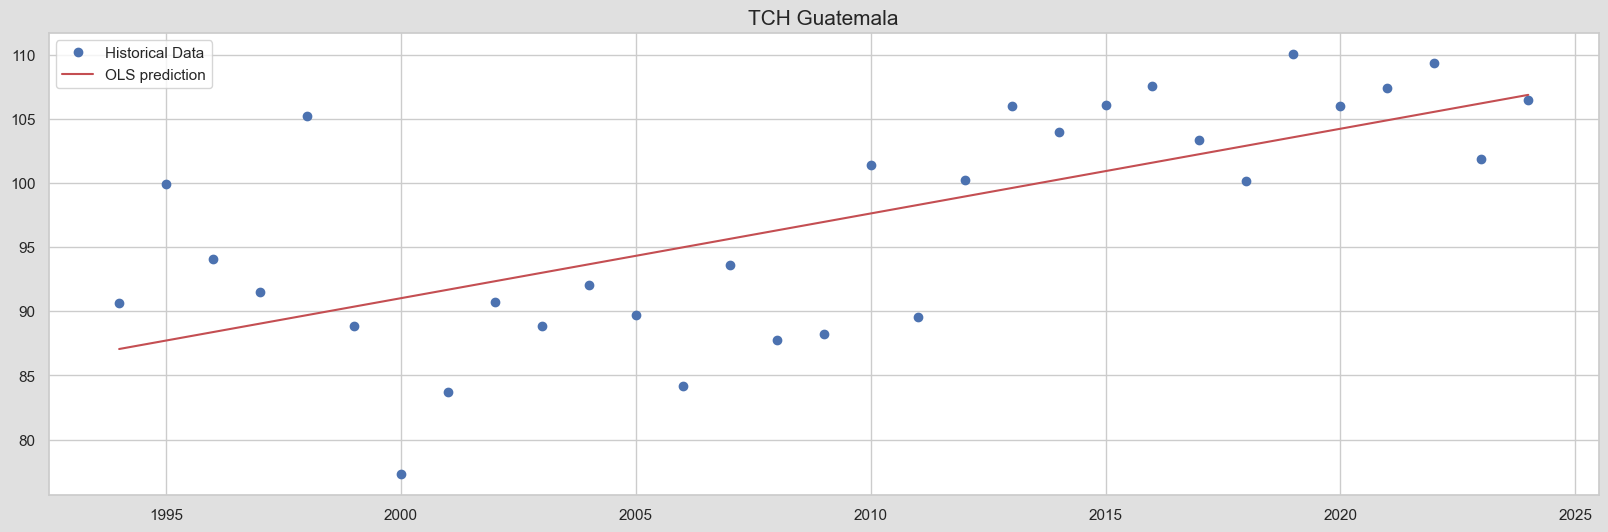

In [8]:
# Plot Predictions vs. Actuals
fig, ax = plt.subplots(figsize=(20,6))
fig.patch.set_facecolor('#E0E0E0')
plt.grid(zorder=0)
ax.plot(df['Año'], df['TCH'], "o", label="Historical Data")
ax.plot(df['Año'], ex_hat, "r", label="OLS prediction")
ax.legend(loc="best")
plt.title("TCH Guatemala",size=15)

### Análisis de Residuos

Se calculan los residuos restando de la serie temporal la tendencia obtenida.
Adicionalmente se calculan variables categóricas para indicar si un año es Niño, Niña o Neutro.

In [9]:
# Detrending for Residuals
threshold = 0.5
df['TCH Trend'] = ex_hat.values
df['TCH Residuals'] = df['TCH'] - df['TCH Trend']
df['NINO'] = (df['ONI'] > threshold).astype(int)
df['NINA'] = (df['ONI'] < -threshold).astype(int)
df['NEUTRO'] = ((df['ONI'] <= threshold) & (df['ONI'] >= -threshold)).astype(int)
df.dropna(inplace=True)
df

,TCH,Rend,Anomaly,ONI,Año,TCH Trend,TCH Residuals,NINO,NINA,NEUTRO
Year,,,,,,,,,,
1994-12-31,90.650000,104.520000,0.323333,0.298056,1994,87.062306,3.587694,0,0,1
1995-12-31,99.910000,99.330000,0.480000,0.388889,1995,87.722270,12.187730,0,0,1
1996-12-31,94.040000,96.710000,-0.170833,0.012222,1996,88.382234,5.657766,0,0,1
1997-12-31,91.520000,101.680000,-0.459167,-0.501944,1997,89.042198,2.477802,0,1,0
1998-12-31,105.250000,99.660000,1.170833,0.929722,1998,89.702162,15.547838,1,0,0
1999-12-31,88.840000,101.940000,-0.055000,0.272222,1999,90.362125,-1.522125,0,0,1
2000-12-31,77.340000,115.220000,-1.224167,-1.217500,2000,91.022089,-13.682089,0,1,0
2001-12-31,83.710000,115.120000,-0.845000,-0.912500,2001,91.682053,-7.972053,0,1,0
2002-12-31,90.700000,113.240000,-0.310833,-0.342500,2002,92.342017,-1.642017,0,0,1


### Serie Temporal de Residuos y Anomalías

<Axes: title={'center': 'Yield Guatemala'}, xlabel='Year'>

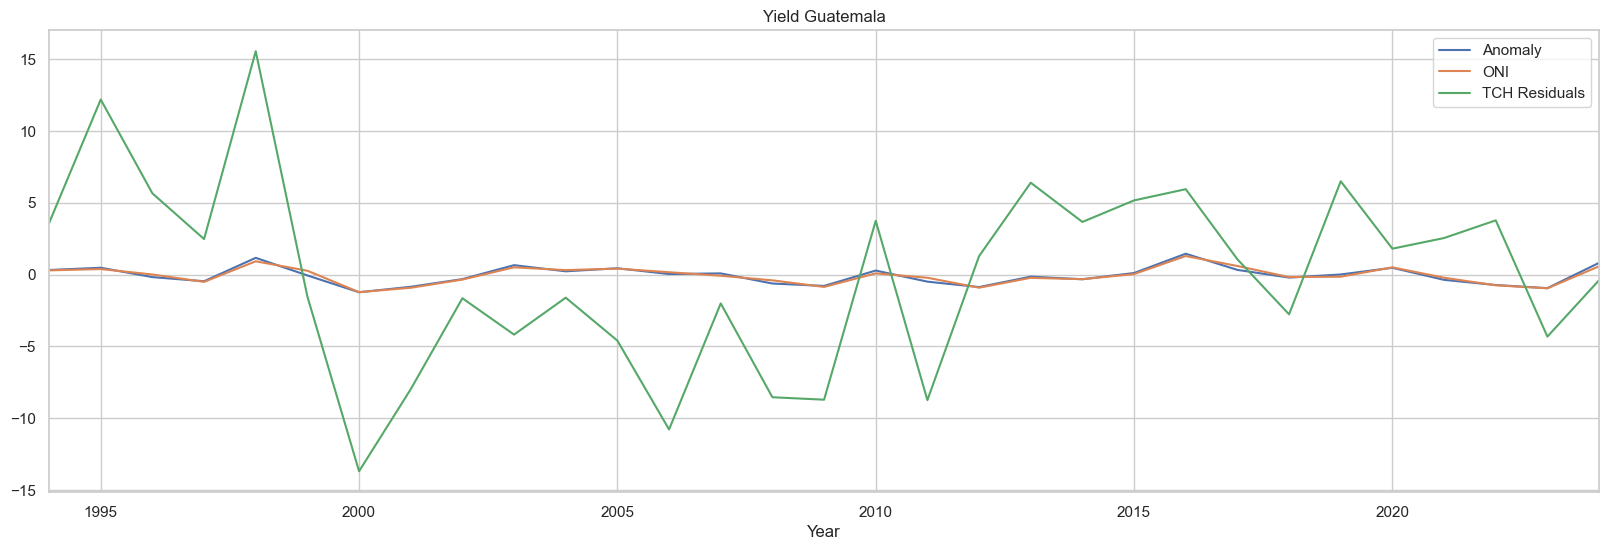

In [10]:
df[['Anomaly','ONI','TCH Residuals']].plot(figsize=(20,6),grid=True,title='Yield Guatemala')

### Correlograma TCH

Se muestra un correlograma para identificar las variables que estén mayormente correlacionadas con el TCH y los residuos de TCH después de la remoción de la tendencia.

<Axes: title={'center': 'Correlograma TCH Guatemala'}>

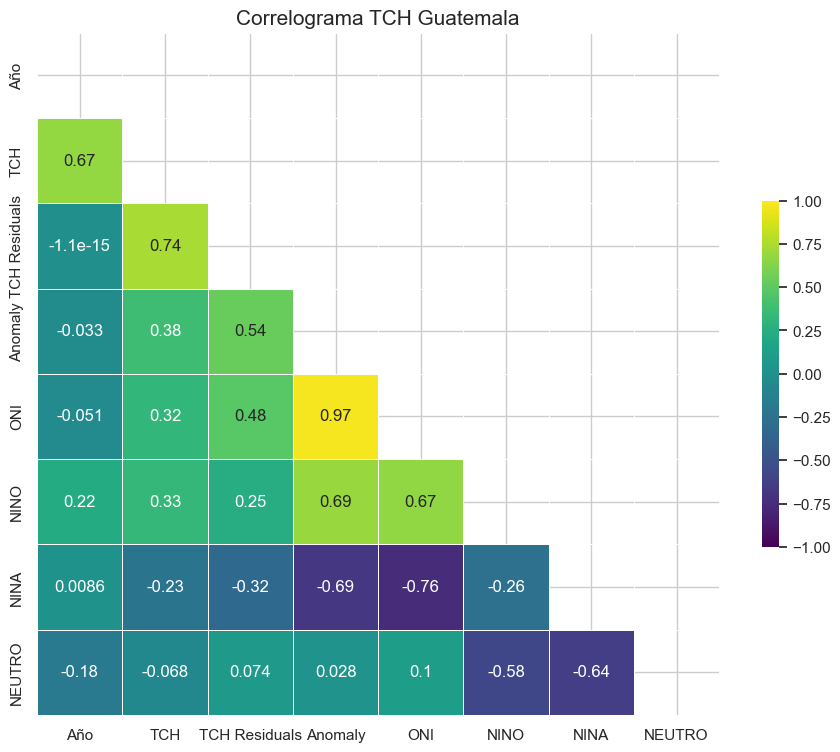

In [11]:
# Compute the correlation matrix
corr = df[['Año','TCH','TCH Residuals','Anomaly','ONI','NINO','NINA','NEUTRO']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="darkgrid")
plt.title("Correlograma TCH Guatemala",size=15)
cmap = 'viridis'
sns.heatmap(corr, mask=mask, vmin = -1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, cmap = cmap)

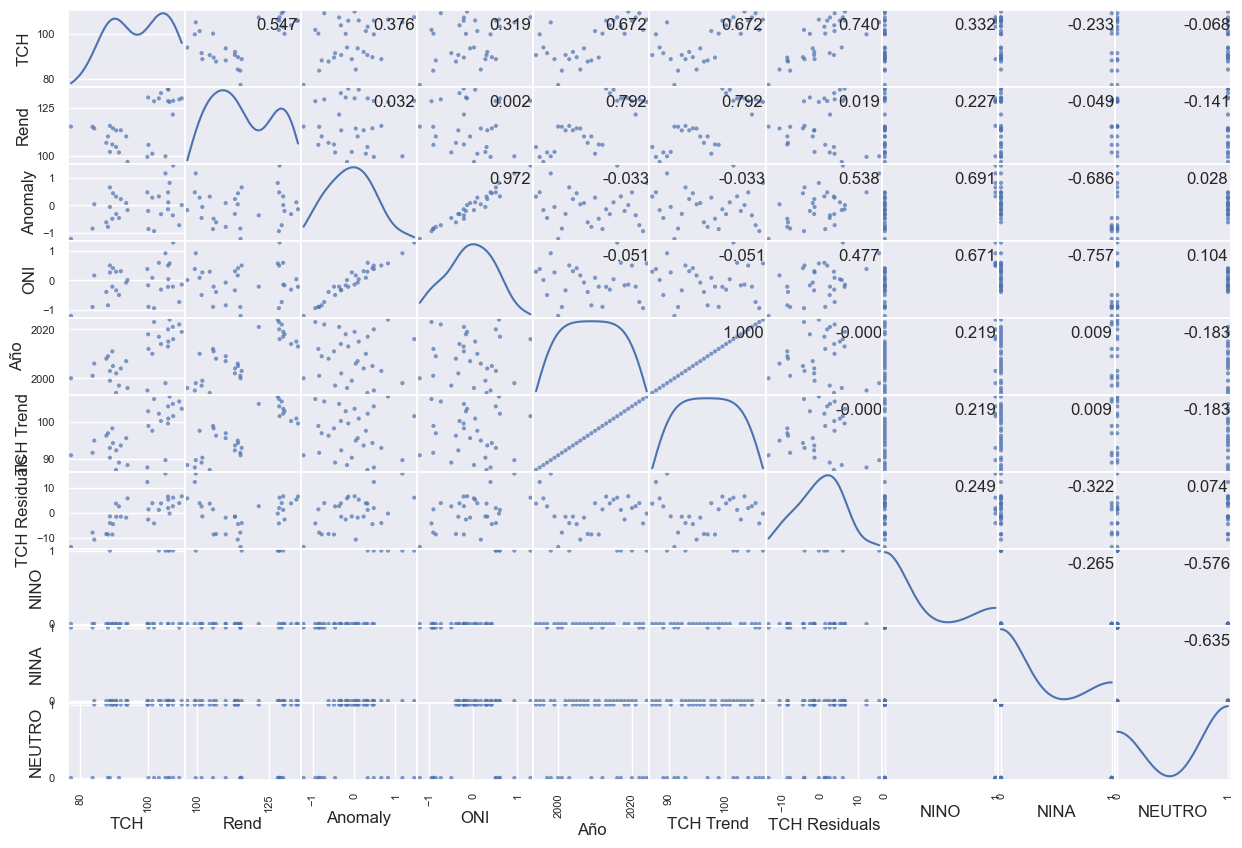

In [12]:
axes = scatter_matrix(df, alpha=0.7,figsize=(15, 10), diagonal='kde')
corr = df.corr().to_numpy()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

Las correlaciones importantes con el TCH ocurren con los períodos **Niño** y la **Anomalía ONI** de forma moderada.

Las correlaciones importantes con los Residuos de TCH ocurren con: **Anomalía ONI** y los períodos **Niño y Niña**.

### Efecto del ENSO sobre TCH

Se filtran los años clasificados como **Niño, Niña y Neutro**, para explorar su distribución en estos períodos

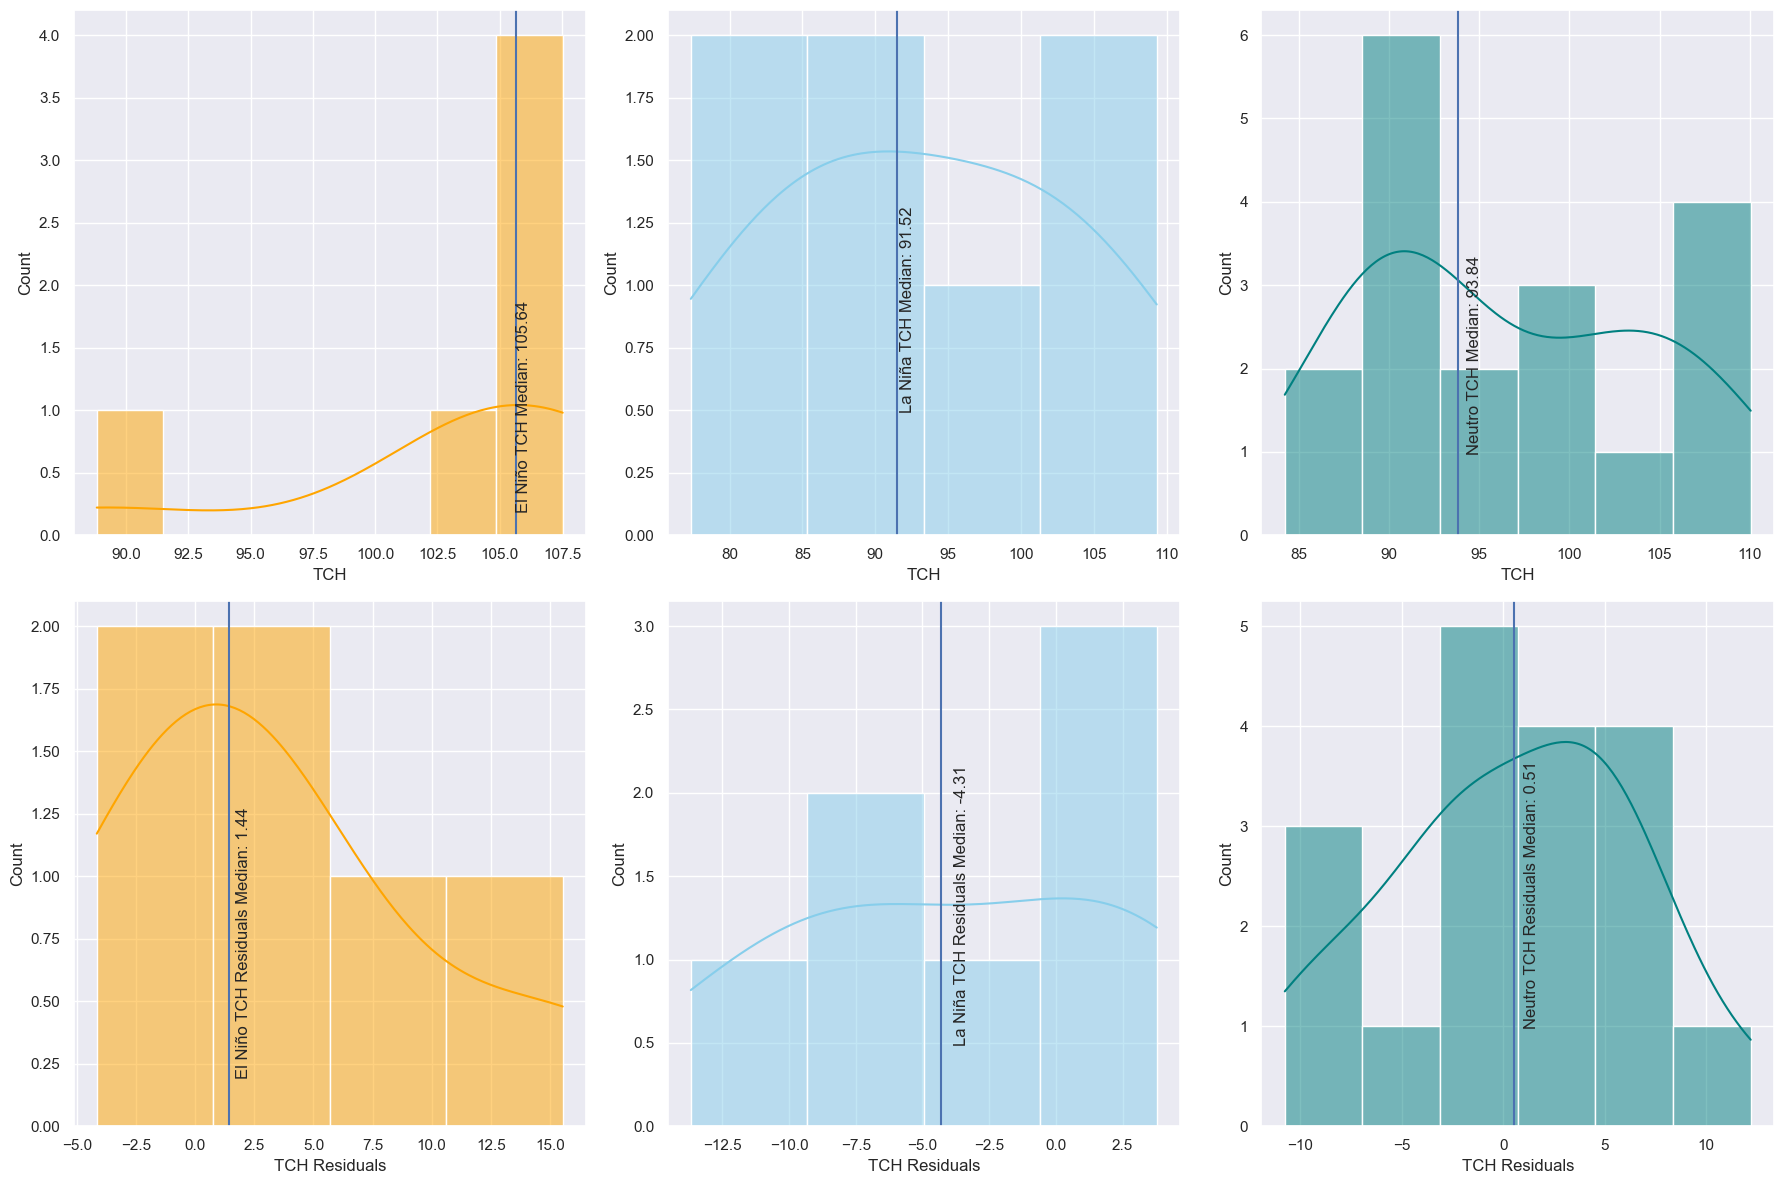

In [13]:
df_niño = df[df['NINO']==1]
df_niña = df[df['NINA']==1]
df_neutro = df[df['NEUTRO']==1]

fig,axs = plt.subplots(2,3,figsize = (18,12))

# El Niño
sns.histplot(data=df_niño, x="TCH", kde=True, color="orange", ax=axs[0,0])
axs[0,0].axvline(df_niño['TCH'].median(),0,1, color ='b')
axs[0,0].text(df_niño['TCH'].median()+0.02,0.2,'El Niño TCH Median: {:.2f}'.format(df_niño['TCH'].median()),rotation=90)

# La Niña
sns.histplot(data=df_niña, x="TCH", kde=True, color="skyblue", ax=axs[0,1])
axs[0,1].axvline(df_niña['TCH'].median(),0,1, color ='b')
axs[0,1].text(df_niña['TCH'].median()+0.2,0.5,'La Niña TCH Median: {:.2f}'.format(df_niña['TCH'].median()),rotation=90)

# Neutro
sns.histplot(data=df_neutro, x="TCH", kde=True, color="teal", ax=axs[0,2])
axs[0,2].axvline(df_neutro['TCH'].median(),0,1, color ='b')
axs[0,2].text(df_neutro['TCH'].median()+0.5,1,'Neutro TCH Median: {:.2f}'.format(df_neutro['TCH'].median()),rotation=90)

# El Niño
sns.histplot(data=df_niño, x="TCH Residuals", kde=True, color="orange", ax=axs[1,0])
axs[1,0].axvline(df_niño['TCH Residuals'].median(),0,1, color ='b')
axs[1,0].text(df_niño['TCH Residuals'].median()+0.3,0.2,'El Niño TCH Residuals Median: {:.2f}'.format(df_niño['TCH Residuals'].median()),rotation=90)

# La Niña
sns.histplot(data=df_niña, x="TCH Residuals", kde=True, color="skyblue", ax=axs[1,1])
axs[1,1].axvline(df_niña['TCH Residuals'].median(),0,1, color ='b')
axs[1,1].text(df_niña['TCH Residuals'].median()+0.5,0.5,'La Niña TCH Residuals Median: {:.2f}'.format(df_niña['TCH Residuals'].median()),rotation=90)

# Neutro
sns.histplot(data=df_neutro, x="TCH Residuals", kde=True, color="teal", ax=axs[1,2])
axs[1,2].axvline(df_neutro['TCH Residuals'].median(),0,1, color ='b')
axs[1,2].text(df_neutro['TCH Residuals'].median()+0.5,1,'Neutro TCH Residuals Median: {:.2f}'.format(df_neutro['TCH Residuals'].median()),rotation=90)

fig.tight_layout()

### Boxplot Efecto Anomalía ONI (Completo)
En este análisis se presentan los escenarios:
- El Niño (ONI mayor a 0.5)
- Neutro (ONI entre -0.5 y 0.5)
- La Niña (ONI menor a -0.5)

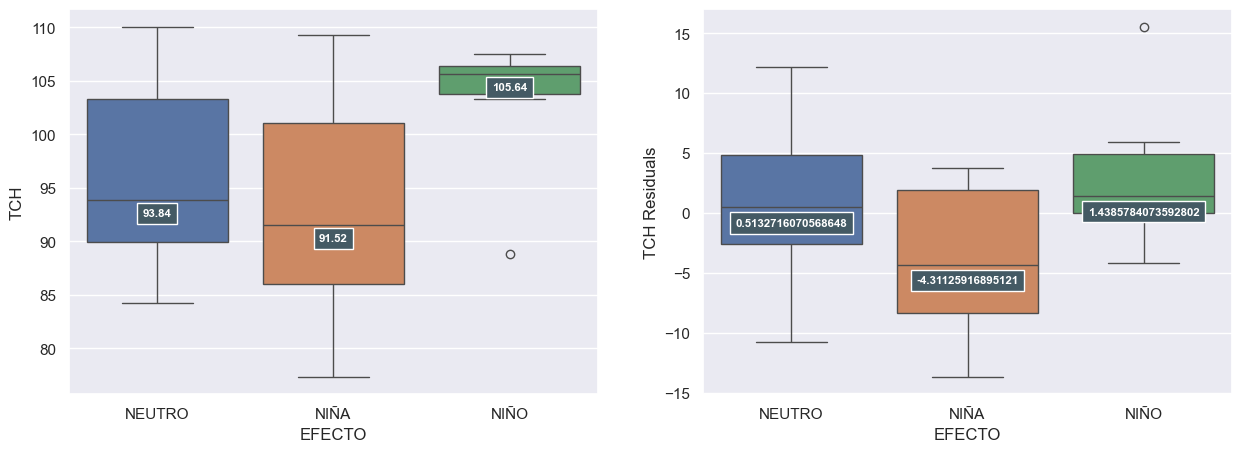

In [14]:
df_boxplot = df

conditions = [
    (df['NINO'] == 1),
    (df['NINA'] == 1),
    (df['NEUTRO'] == 1)]
choices = ['NIÑO', 'NIÑA', 'NEUTRO']
df_boxplot['EFECTO'] = np.select(conditions, choices, default='black')


fig, ax =plt.subplots(1,2, figsize=(15, 5))
plt.set_loglevel('WARNING')

my_pal = {"NEUTRO": "g", "NIÑA": "b", "NIÑO":"r"}

# TCH
medians = df_boxplot.groupby(['EFECTO'])['TCH'].median()
means = df_boxplot.groupby(['EFECTO'])['TCH'].mean()
df_TCH_full = pd.concat([medians,means],axis=1)
df_TCH_full.columns = ['TCH Medians', 'TCH Means']
box_plot = sns.boxplot(data=df_boxplot, x="EFECTO", y="TCH",ax=ax[0],hue="EFECTO",order=df_TCH_full.index)

vertical_offset = df_boxplot['TCH'].median() * 0.015 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] - vertical_offset,medians.iloc[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold',bbox=dict(facecolor='#445A64'))

# Diferenciales de TCH
medians = df_boxplot.groupby(['EFECTO'])['TCH Residuals'].median()
means = df_boxplot.groupby(['EFECTO'])['TCH Residuals'].mean()
df_TCHR_full = pd.concat([medians,means],axis=1)
df_TCHR_full.columns = ['TCH Residuals Medians', 'TCH Residuals Means']
box_plot = sns.boxplot(data=df_boxplot, x="EFECTO", y="TCH Residuals",ax=ax[1],hue="EFECTO",order=df_TCHR_full.index)

vertical_offset = df_boxplot['TCH Residuals'].median() * 1.5 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] - vertical_offset,medians.iloc[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold',bbox=dict(facecolor='#445A64'))

df_TCH_full = pd.concat([df_TCH_full,df_TCHR_full],axis=1)

In [15]:
df_TCH_full

,TCH Medians,TCH Means,TCH Residuals Medians,TCH Residuals Means
EFECTO,,,,
NEUTRO,93.84,96.451111,0.513272,0.405963
NIÑA,91.52,93.181429,-4.311259,-3.874616
NIÑO,105.64,102.904117,1.438578,3.302496


### Boxplot Efecto Anomalía ONI (Fuerte)
En este análisis se presentan los escenarios:
- El Niño (ONI mayor a 1)
- Neutro (ONI entre -1 y 1)
- La Niña (ONI menor a -1)

In [16]:
threshold = 1.0
df['NINO'] = (df['ONI'] > threshold).astype(int)
df['NINA'] = (df['ONI'] < -threshold).astype(int)
df['NEUTRO'] = ((df['ONI'] <= threshold) & (df['ONI'] >= -threshold)).astype(int)

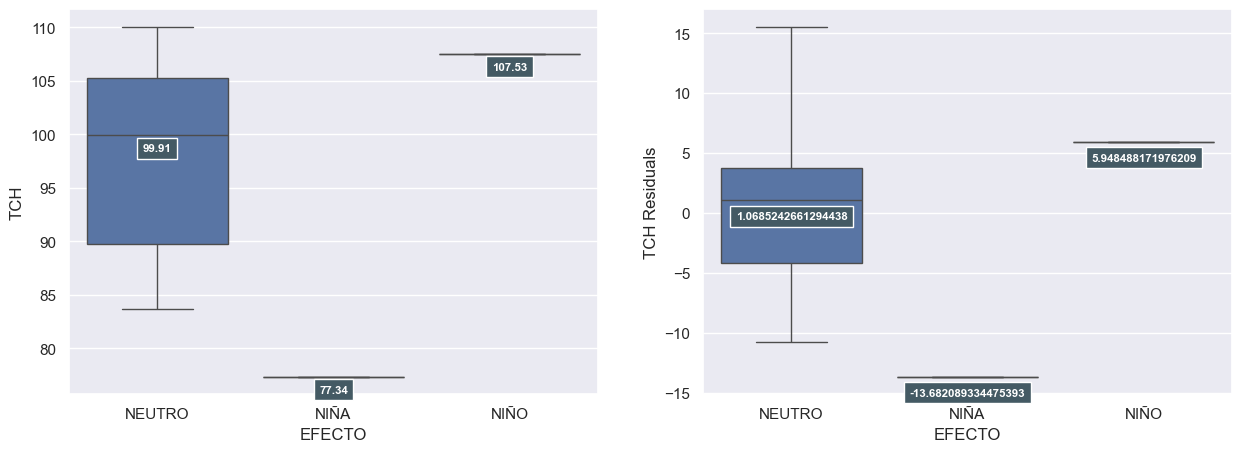

In [17]:
df_boxplot = df

conditions = [
    (df['NINO'] == 1),
    (df['NINA'] == 1),
    (df['NEUTRO'] == 1)]
choices = ['NIÑO', 'NIÑA', 'NEUTRO']
df_boxplot['EFECTO'] = np.select(conditions, choices, default='black')


fig, ax =plt.subplots(1,2, figsize=(15, 5))
plt.set_loglevel('WARNING')

my_pal = {"NEUTRO": "g", "NIÑA": "b", "NIÑO":"r"}

# TCH
medians = df_boxplot.groupby(['EFECTO'])['TCH'].median()
means = df_boxplot.groupby(['EFECTO'])['TCH'].mean()
df_TCH_fuerte = pd.concat([medians,means],axis=1)
df_TCH_fuerte.columns = ['TCH Medians', 'TCH Means']
box_plot = sns.boxplot(data=df_boxplot, x="EFECTO", y="TCH",ax=ax[0],hue="EFECTO",order=df_TCH_fuerte.index)

vertical_offset = df_boxplot['TCH'].median() * 0.015 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] - vertical_offset,medians.iloc[xtick], 
            horizontalalignment='center',size='x-small',color='white',weight='semibold',bbox=dict(facecolor='#445A64'))

# Diferenciales de TCH
medians = df_boxplot.groupby(['EFECTO'])['TCH Residuals'].median()
means = df_boxplot.groupby(['EFECTO'])['TCH Residuals'].mean()
df_TCHR_fuerte = pd.concat([medians,means],axis=1)
df_TCHR_fuerte.columns = ['TCH Residuals Medians', 'TCH Residuals Means']
box_plot = sns.boxplot(data=df_boxplot, x="EFECTO", y="TCH Residuals",ax=ax[1],hue="EFECTO",order=df_TCHR_fuerte.index)

vertical_offset = df_boxplot['TCH Residuals'].median() * 1.5 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] - vertical_offset,medians.iloc[xtick], 
            horizontalalignment='center',size='x-small',color='white',weight='semibold',bbox=dict(facecolor='#445A64'))

df_TCH_fuerte = pd.concat([df_TCH_fuerte,df_TCHR_fuerte],axis=1)

In [18]:
df_TCH_fuerte

,TCH Medians,TCH Means,TCH Residuals Medians,TCH Residuals Means
EFECTO,,,,
NEUTRO,99.91,97.273955,1.068524,0.266676
NIÑA,77.34,77.340000,-13.682089,-13.682089
NIÑO,107.53,107.530000,5.948488,5.948488


### Interpretación de Boxplots

Se muestran resultados para TCH y Residuos (diferencial) de TCH debidos a años Niño, Niña o Neutros. Se entiende que el efecto de un año **Niño/Niña/Neutro** es observable en la caña del siguiente año.

In [19]:
df_TCH_full

,TCH Medians,TCH Means,TCH Residuals Medians,TCH Residuals Means
EFECTO,,,,
NEUTRO,93.84,96.451111,0.513272,0.405963
NIÑA,91.52,93.181429,-4.311259,-3.874616
NIÑO,105.64,102.904117,1.438578,3.302496


In [20]:
df_TCH_fuerte

,TCH Medians,TCH Means,TCH Residuals Medians,TCH Residuals Means
EFECTO,,,,
NEUTRO,99.91,97.273955,1.068524,0.266676
NIÑA,77.34,77.340000,-13.682089,-13.682089
NIÑO,107.53,107.530000,5.948488,5.948488


#### Para el **valor absoluto de TCH** resume lo siguiente:
- En años **Niño Típicos** el TCH se centraría alrededor de **102.90**
- En **Niños Fuertes** el TCH podría alcanzar hasta **107.53**
- En años **Neutros** el TCH se centraría entre **96.45** y **97.27**
- En años **Niña Típicos** el TCH se centraría en **93.18**
- En años **Niña Fuertes** el TCH podría alcanzar hasta **77.34**

Estos valores son para el promedio actual de TCH, sin embargo como se explicó al inicio, este valor está afectado por la tendencia creciente desde el inicio del período de análisis y que se deben a mejoras graduales que se han realizado en el proceso de producción de caña. Por ello es más útil el uso del **diferencial de TCH** , ya que puede utilizarse para *sumar/restar* sobre las metas actuales.

#### Para los **Residuos (Diferencial) de TCH** resume lo siguiente:
- En años **Niño Típicos** el diferencial de TCH se centraría alrededor de **+3.30**,
- En años **Niños Fuertes** el diferencial de TCH podría alcanzar hasta **+5.95**
- En años **Neutros** el diferencial de TCH se centraría entre **+0.27 y +0.41**
- En años **Niña Típicos** el diferencial de TCH se centraría en **-3.87**
- En años **Niña Fuertes** el diferencial de TCH podría alcanzar hasta **-13.68**

### Prueba Estadística Two Sample t-Test para Medias Distintas

Los boxplots muestran que existe intersección entre las distribuciones de TCH para años Niño, Niña y Neutro. Esto mismo ocurre con los residuos. Por lo que se hace necesario hacer una pruebas estadísticas de hipótesis para verificar si realmente la diferencia observada tiene significancia estadística.

Para ello se conducirán pruebas de hipótesis, tanto para los valores de TCH absolutos como para los Residuos.

### Pruebas de Hipótesis sobre Valores Absolutos de TCH

In [21]:
df = pd.concat([oni_df,gt_yield_df],axis=1)
df = df[['TCH','Rend','Anomaly','ONI','Año']]
df['Anomaly'] = df.Anomaly.shift(1)
df['ONI'] = df.ONI.shift(1)
df = df.iloc[1:]

threshold = 0.5
df['TCH Trend'] = ex_hat.values
df['TCH Residuals'] = df['TCH'] - df['TCH Trend']
df['NINO'] = (df['ONI'] > threshold).astype(int)
df['NINA'] = (df['ONI'] < -threshold).astype(int)
df['NEUTRO'] = ((df['ONI'] <= threshold) & (df['ONI'] >= -threshold)).astype(int)
df.dropna(inplace=True)
df

,TCH,Rend,Anomaly,ONI,Año,TCH Trend,TCH Residuals,NINO,NINA,NEUTRO
Year,,,,,,,,,,
1994-12-31,90.650000,104.520000,0.323333,0.298056,1994,87.062306,3.587694,0,0,1
1995-12-31,99.910000,99.330000,0.480000,0.388889,1995,87.722270,12.187730,0,0,1
1996-12-31,94.040000,96.710000,-0.170833,0.012222,1996,88.382234,5.657766,0,0,1
1997-12-31,91.520000,101.680000,-0.459167,-0.501944,1997,89.042198,2.477802,0,1,0
1998-12-31,105.250000,99.660000,1.170833,0.929722,1998,89.702162,15.547838,1,0,0
1999-12-31,88.840000,101.940000,-0.055000,0.272222,1999,90.362125,-1.522125,0,0,1
2000-12-31,77.340000,115.220000,-1.224167,-1.217500,2000,91.022089,-13.682089,0,1,0
2001-12-31,83.710000,115.120000,-0.845000,-0.912500,2001,91.682053,-7.972053,0,1,0
2002-12-31,90.700000,113.240000,-0.310833,-0.342500,2002,92.342017,-1.642017,0,0,1


#### Primera Prueba de Hipótesis: La media de TCH en año Niño es mayor a la media de TCH en año Niña
- Sea $\mu_1$ la media de TCH en años Niño, $\mu_2$ la media de TCH en años Niña.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \geq \mu_2$

In [22]:
ttest_ind(df[df['NINO']==1]['TCH'],df[df['NINA']==1]['TCH'],alternative = 'larger',usevar = 'unequal', value = 0)

(1.899527920806715, 0.04305651062563101, 10.200170508845902)

Con un nivel de confianza del **95%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de TCH en años Niño es mayor que la media de TCH en años Niña.***

#### Segunda Prueba de Hipótesis: La media de TCH en año Niño es mayor a la media de TCH en año Neutro
- Sea $\mu_1$ la media de TCH en años Niño, $\mu_2$ la media de TCH en años Neutros.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \geq \mu_2$

In [23]:
ttest_ind(df[df['NINO']==1]['TCH'],df[df['NEUTRO']==1]['TCH'],alternative = 'larger',usevar = 'unequal', value = 0)

(1.882038310268259, 0.0451792798358766, 9.630041274820336)

Con un nivel de confianza del **95%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de TCH en años Niño es mayor que la media de TCH en años Neutros.***

#### Tercera Prueba de Hipótesis: La media de TCH en año Niña es menor a la media de TCH en año Neutro
- Sea $\mu_1$ la media de TCH en años Niña, $\mu_2$ la media de TCH en años Neutros.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \leq \mu_2$

In [24]:
ttest_ind(df[df['NINA']==1]['TCH'],df[df['NEUTRO']==1]['TCH'],alternative = 'smaller',usevar = 'unequal', value = 0)

(-0.7060809381426593, 0.24956362700731527, 8.455907980511192)

Con un nivel de confianza del **75%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de TCH en años Niña es menor que la media de TCH en años Neutros.***

### Pruebas de Hipótesis sobre Valores Residuales (Diferenciales) de TCH

#### Primera Prueba de Hipótesis: La media de Diferenciales de TCH en año Niño es mayor a la media de Diferenciales de TCH en año Niña
- Sea $\mu_1$ la media de Diferenciales de TCH en años Niño, $\mu_2$ la media de Diferenciales de TCH en años Niña.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \geq \mu_2$

In [25]:
ttest_ind(df[df['NINO']==1]['TCH Residuals'],df[df['NINA']==1]['TCH Residuals'],alternative = 'larger',usevar = 'unequal', value = 0)

(1.9162775868436774, 0.041376811797698664, 10.568049681750109)

Con un nivel de confianza del **95%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de Diferenciales de TCH en años Niño es mayor que la media de Diferenciales de TCH en años Niña.***

#### Segunda Prueba de Hipótesis: La media de Diferenciales de TCH en año Niño es mayor a la media de Diferenciales de TCH en año Neutro
- Sea $\mu_1$ la media de Diferenciales de TCH en años Niño, $\mu_2$ la media de Diferenciales de TCH en años Neutros.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \geq \mu_2$

In [26]:
ttest_ind(df[df['NINO']==1]['TCH Residuals'],df[df['NEUTRO']==1]['TCH Residuals'],alternative = 'larger',usevar = 'unequal', value = 0)

(0.9215642980096398, 0.19205549694093554, 7.877537382988013)

Con un nivel de confianza del **80%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de Diferenciales de TCH en años Niño es mayor que la media de Diferenciales de TCH en años Neutros.***

#### Tercera Prueba de Hipótesis: La media de Diferenciales de TCH en año Niña es menor a la media de Diferenciales de TCH en año Neutro
- Sea $\mu_1$ la media de Diferenciales de TCH en años Niña, $\mu_2$ la media de Diferenciales de TCH en años Neutros.
- Sea $H_0$ la hipótesis nula: $\mu_1 = \mu_2$ y por lo tanto $H_1$ la hipótesis alternativa $\mu_1 \leq \mu_2$

In [27]:
ttest_ind(df[df['NINA']==1]['TCH Residuals'],df[df['NEUTRO']==1]['TCH Residuals'],alternative = 'smaller',usevar = 'unequal', value = 0)

(-1.4831472299455843, 0.08400641125973156, 10.286743758952202)

Con un nivel de confianza del **91%** se rechaza la hipótesis nula y ***existe evidencia estadística que la media de TCH en años Niña es menor que la media de TCH en años Neutros.***